In [1]:
import warnings
warnings.simplefilter(action='ignore',)

import os # Kernel dies when plotting after importing torch
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch 
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

GeForce GTX 1650 with Max-Q Design
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
NUM_EPOCHS = 100
EARLY_STOP = 10
NUM_CLASS = 10

NUM_TRAIN = 60000
NUM_TEST = 10000

BATCH_SIZE = 100
LEARN_RATE = 0.001

In [3]:
train_dataset = torchvision.datasets.MNIST(root='data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

train_dataset.data = train_dataset.data[:NUM_TRAIN]
train_dataset.targets = train_dataset.targets[:NUM_TRAIN]
train, valid = random_split(train_dataset,[int(NUM_TRAIN*0.8),int(NUM_TRAIN*0.2)])

test_dataset.data = test_dataset.data[:NUM_TEST]
test_dataset.targets = test_dataset.targets[:NUM_TEST]

train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid,
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False)

In [4]:
class CNN_model(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_model, self).__init__()
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc1 = torch.nn.Linear(7*7*32, 256)
        self.fc2 = torch.nn.Linear(256, 64)
        self.fc3 = torch.nn.Linear(64, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [5]:
model = CNN_model(NUM_CLASS).to(device)

cost_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
print(model)

CNN_model(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [6]:
ACC,LOSS,VAL_ACC,VAL_LOSS = [],[],[],[]

early_step, total_step = 0, len(train_loader)
min_valid_loss = np.inf

def calculate_acc(outputs, labels, total, correct):
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    return total,correct
    
for epoch in range(NUM_EPOCHS):    
    train_acc,train_total,valid_acc,valid_total = 0,0,0,0
    train_loss,valid_loss = 0.0,0.0
    
    for images, labels in tqdm(train_loader, desc="Epoch[{:2d}/{}]".format(epoch+1,NUM_EPOCHS)):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = cost_func(outputs, labels)
        train_total, train_acc = calculate_acc(outputs, labels, train_total, train_acc)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = cost_func(outputs, labels)
        valid_total, valid_acc = calculate_acc(outputs, labels, valid_total, valid_acc)
        valid_loss += loss.item() 

    ACC.append(train_acc/train_total)
    LOSS.append(train_loss)
    VAL_ACC.append(valid_acc/valid_total)
    VAL_LOSS.append(valid_loss)
    
    print('train_acc: {:5.2f} | train_loss: {:6.3f} | valid_acc: {:5.2f} | valid_loss: {:6.3f}'.format(100*(train_acc/train_total),(train_loss /len(train_loader)),100*(valid_acc/valid_total),(valid_loss /len(valid_loader))))
    
    if min_valid_loss > valid_loss:
        print('\nValidation loss decreased({:4f}--->{:4f})...saving model'.format(min_valid_loss,valid_loss))
        
        early_step, min_valid_loss = 0, valid_loss     
        torch.save(model.state_dict(), 'saved_model.pth')
    else:
        early_step += 1
        if early_step > EARLY_STOP:
            print(f"\nNo improvment {EARLY_STOP} consecutive epochs, early stopping.")
            break

Epoch[ 1/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 94.82 | train_loss:  0.173 | valid_acc: 97.97 | valid_loss:  0.063

Validation loss decreased( inf--->7.517388)...saving model


Epoch[ 2/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 98.29 | train_loss:  0.055 | valid_acc: 98.11 | valid_loss:  0.060

Validation loss decreased(7.517388--->7.181022)...saving model


Epoch[ 3/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 98.76 | train_loss:  0.038 | valid_acc: 98.32 | valid_loss:  0.056

Validation loss decreased(7.181022--->6.686600)...saving model


Epoch[ 4/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.05 | train_loss:  0.030 | valid_acc: 98.49 | valid_loss:  0.053

Validation loss decreased(6.686600--->6.353654)...saving model


Epoch[ 5/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.17 | train_loss:  0.025 | valid_acc: 98.84 | valid_loss:  0.037

Validation loss decreased(6.353654--->4.425279)...saving model


Epoch[ 6/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.33 | train_loss:  0.021 | valid_acc: 98.78 | valid_loss:  0.040


Epoch[ 7/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.51 | train_loss:  0.015 | valid_acc: 98.93 | valid_loss:  0.042


Epoch[ 8/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.48 | train_loss:  0.015 | valid_acc: 98.87 | valid_loss:  0.043


Epoch[ 9/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.61 | train_loss:  0.012 | valid_acc: 98.78 | valid_loss:  0.050


Epoch[10/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.64 | train_loss:  0.011 | valid_acc: 98.86 | valid_loss:  0.044


Epoch[11/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.56 | train_loss:  0.013 | valid_acc: 98.72 | valid_loss:  0.050


Epoch[12/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.68 | train_loss:  0.010 | valid_acc: 98.79 | valid_loss:  0.046


Epoch[13/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.69 | train_loss:  0.009 | valid_acc: 99.10 | valid_loss:  0.035

Validation loss decreased(4.425279--->4.160746)...saving model


Epoch[14/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.73 | train_loss:  0.008 | valid_acc: 98.69 | valid_loss:  0.059


Epoch[15/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.74 | train_loss:  0.007 | valid_acc: 98.80 | valid_loss:  0.051


Epoch[16/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.79 | train_loss:  0.007 | valid_acc: 99.02 | valid_loss:  0.045


Epoch[17/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.83 | train_loss:  0.005 | valid_acc: 98.08 | valid_loss:  0.094


Epoch[18/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.68 | train_loss:  0.009 | valid_acc: 98.98 | valid_loss:  0.044


Epoch[19/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.80 | train_loss:  0.007 | valid_acc: 99.10 | valid_loss:  0.040


Epoch[20/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.89 | train_loss:  0.003 | valid_acc: 99.11 | valid_loss:  0.046


Epoch[21/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.78 | train_loss:  0.007 | valid_acc: 98.80 | valid_loss:  0.062


Epoch[22/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.88 | train_loss:  0.004 | valid_acc: 98.98 | valid_loss:  0.049


Epoch[23/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.80 | train_loss:  0.006 | valid_acc: 98.92 | valid_loss:  0.053


Epoch[24/100]:   0%|          | 0/480 [00:00<?, ?it/s]

train_acc: 99.83 | train_loss:  0.005 | valid_acc: 99.11 | valid_loss:  0.051

No improvment 10 consecutive epochs, early stopping.


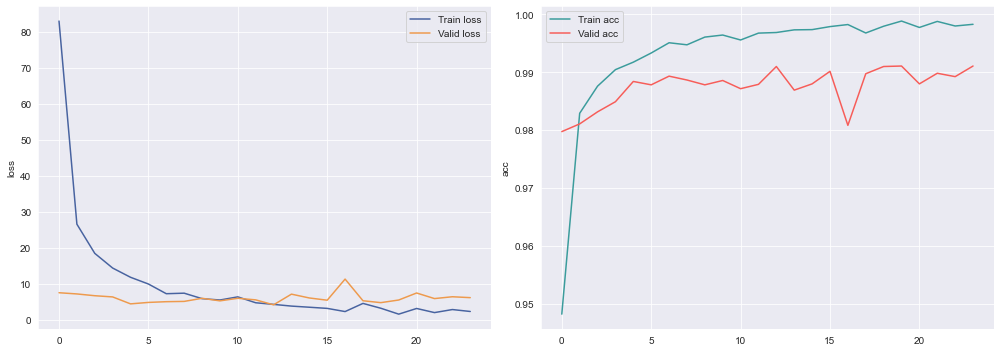

In [7]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(LOSS, label="Train loss", color="#4863A0")
ax[0].plot(VAL_LOSS, label="Valid loss", color="#EE9A4D")
ax[0].set_ylabel('loss')
ax[0].legend(loc="upper right")

ax[1].plot(ACC, label="Train acc", color="#3B9C9C")
ax[1].plot(VAL_ACC, label="Valid acc", color="#F75D59")
ax[1].set_ylabel('acc')
ax[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

In [8]:
model = CNN_model(NUM_CLASS).to(device)
model.load_state_dict(torch.load('saved_model.pth'))
model.eval()  

def calculate_acc(outputs, labels, total, correct):
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    return total,correct

with torch.no_grad():
    acc,total = 0,0
    for images, labels in tqdm(test_loader, desc="Test"):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        total, acc = calculate_acc(outputs, labels, total, acc)
    print('Accuracy of 10000 test images: {} %'.format(100*acc/total))

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy of 10000 test images: 99.15 %
